# Progetto DL24: YesWeKAN

introduzione

### Importazione librerie

Importiamo tutte le librerie necessarie per il notebook:

In [1]:
# Libreirie di sistema
import os
import random
import base64
import datetime

# Array, dataframe e tensori
import numpy as np
import pandas as pd
import tensorflow as tf

# Modelli ML & DL
import keras
from tensorflow.keras.layers import Dense
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import check_random_state
from keras_tuner import HyperModel, GridSearch, RandomSearch
from keras_tuner.tuners import BayesianOptimization
import lime # fornisce metodi di spiegabilità algoritmic
import lime.lime_tabular 

# Librerie grafiche
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator  # strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML  # funzioni utilizzate per visualizzare output HTML nel notebook
import matplotlib.pyplot as plt # fornisce funzioni per generare grafici
import seaborn as sns
import networkx as nx # fornisce funzioni per la creazione di grafi

# Librerie custom
import preprocess_dataset as ut
from tfkan import DenseKAN

Impostiamo in seme casuale a 0 per poter rendere l'esperimento ripetibile:

In [2]:
# Valore del seme causale
seed_value = 0

# Impostazione dei semi casuali per os, random, numpy e tensorflow
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Controllo che il seme sia stato correttamente impostato
check_random_state(seed_value)

RandomState(MT19937) at 0x1FF970FDF40

## Dataset

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichiamo il dataset in un dataframe pandas: 

In [32]:
# Variabili del dataset
DATASET_NAME = 'LengthOfStay'
FEATURES = [ # Nomi feature accorciati (per migliorare la visualizzazione nei grafici)
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'facid'
]

# Numero feature usate dal modello
N_FEATURES = len(FEATURES)

# Definisce i colori da usare per le barre
COLORS = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  

# Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

# Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

### Analisi del dataset

Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record

In [4]:
# Genera statistiche sul dataset
fsg = FeatureStatisticsGenerator()
dataframes = [ {'table': df, 'name': DATASET_NAME}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

# Impostazioni per la visualizzazione
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)

# Mostra analisi grafica
display(HTML(html)) 

c:\Users\matte\documents\KAN\Lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Osserviamo che non sono presenti valori mancanti in nessun attributo, ma sono presenti molti attributi sbilanciati nella distribuzione dei loro valori

### Pre-processing del dataset

Importando il dataset e visualizzando i record ci accorgiamo che ci sono degli attributi non numerici, come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.

Gli attributi a cui dovremo dare una codifica numerica sono:
    
- **vdate** e **discharged**: sono la data di inizio e fine del ricovero; si potrebbero codificare come interi da 0 a 365 (o 366 a seconda dell'anno), tuttavia per il nostro scopo è opportuno eliminare la data di fine ricovero, in quanto non è un'informazione che ci dovrebbe essere nota al momento della predizione.

- **rcount**: è il numero di ricoveri pregressi del paziente; trasformeremo il valore 5+ in 5.

- **gender**: è il genere del paziente; trasformeremo M in 0 ed F in 1.

- **facid**: è un identificativo del reparto ospedaliero; trasformeremo le lettere in numeri incrementali.

- **eid**: è un identificativo univoco del record nel dataset; non porta alcuna informazione, per cui non lo consideriamo.

Dopo aver eliminato le colonne che non consideriamo, ma prima di trasformare dati categorici in numerici, ci salviamo una copia del dataset per i modelli di ML, che possono gestire anche dati categorici.

In [33]:
# Rimuove la colonna "discharged"
df.drop("discharged", axis=1, inplace=True) 

# Rimuove la colonna "eid"
df.drop("eid", axis=1, inplace=True)

# Codifica del 5+ in 5 in rcount
keys = sorted(df["rcount"].unique())
values = range(len(keys))
df.replace({"rcount": dict(zip(keys, values))}, inplace=True)

# Codifica delle date
keys = df["vdate"].unique()
values = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in keys]
df.replace({"vdate": dict(zip(keys, values))}, inplace=True)

# Codifica del genere
keys = df["gender"].unique()
values = range(len(keys))
df.replace({"gender": dict(zip(keys, values))}, inplace=True)

# Codifica del facid
keys = df["facid"].unique()
values = range(len(keys))
df.replace({"facid": dict(zip(keys, values))}, inplace=True)

Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati.
Svolgiamo quindi una standardizzazione MinMax, per portare tutti i valori nell'intervallo [0, 1]. La svolgiamo attraverso la funzione `standardize`, inserita nella nostra libreria.

In [34]:
# Standardizzazione degli attributi del dataset
df = df.astype(float)
df.iloc[:, :-1] = ut.standardize(df.iloc[:, :-1])

### Separazione del dataset

A questo punto il dataset ha solamente valori numerici. Separiamo i training set, validation set e test set. Dopo esserci salvati in alcuni csv la separazione, convertiamo il dataframe in un tensore di Tensorflow.

In [90]:
# Definizione rapporto di split
TEST_RATIO = 0.20

# Separazione train, test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=TEST_RATIO)

# Creazione dei dataset di train, test in csv
x_train.to_csv("datasets/x_train.csv", index=False)
y_train.to_csv("datasets/y_train.csv", index=False)
x_test.to_csv("datasets/x_test.csv", index=False)
y_test.to_csv("datasets/y_test.csv", index=False)

# Conversione del dataframe in tensore
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

# Stampa le dimensioni dei nuovi dataset creati
print("train: ", x_train.shape," test: ",  x_test.shape)

train:  (80000, 25)  test:  (20000, 25)


KFold

In [91]:
kfold = KFold(n_splits=4, shuffle=True, random_state=0)
train_val_indices = list(kfold.split(x_train))

x_train_fold_list = []
y_train_fold_list = []
x_val_fold_list = []
y_val_fold_list = []
for train_indices, val_indices in train_val_indices:
    x_train_fold_list.append(tf.gather(x_train, train_indices))
    x_val_fold_list.append(tf.gather(x_train, val_indices))
    y_train_fold_list.append(tf.gather(y_train, train_indices))
    y_val_fold_list.append(tf.gather(y_train, val_indices))

training_validation_set = list(zip(x_train_fold_list, y_train_fold_list, x_val_fold_list, y_val_fold_list))

Per cercare di dare una risposta alla domanda che guida il nostro progetto, dobbiamo valutare se l'architettura KAN recentemente introdotta possa costituire una valida alternativa agli approcci di apprendimento allo stato dell'arte dalle reti fully connected agli algoritmi più tradizionali.

Per farlo dobbiamo confrontare diversi modelli sia in termini di prestazioni che in termini di equità algoritmica.

Utilizzeremo le metriche tipiche di un task di regressione cioè **MSE**, **MAE** e **RMSE** (quest'ultima è stata definita da noi in quanto non presente nella suite di Tensorflow).

In [92]:
# Lista di metriche necessarie per valutare le performance 
METRICS_NAME = {"mean_absolute_error":"mae", "mean_squared_error":"mse", "root_mean_squared_error":"rmse"}

METRICS = [tf.keras.metrics.get(metric_name) for metric_name in METRICS_NAME]
for metric in METRICS:
    metric.name = METRICS_NAME[metric.name]

BATCH_SIZE = 128
EPOCHS = 10
LOSS = "mae"

# Lista performance dei vari modelli
histories = {}

# Lista dei modelli addestrati di DL e ML
elenco_modelli = {}

In [93]:
def training(model):
    total_history = {}
    for fold, (x_train_fold, y_train_fold, x_val_fold, y_val_fold) in enumerate(training_validation_set):
        print(f"Fold {fold + 1}")
        history = model.fit(x_train_fold, y_train_fold, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val_fold, y_val_fold), verbose=1)

        for key, value in history.history.items():
            if key not in total_history:
                total_history[key] = value
            else:
                total_history[key] += value
    return total_history

def trainingML(model):
    for x_train_fold, y_train_fold, _, __ in training_validation_set:
        model.fit(x_train_fold, y_train_fold)

# Definizione architettura KAN Classica
Si ricordi che ogni livello contiene $inputs_l$ * $units_l$ funzioni spline, ognuna delle quali ha formula $\phi(x) = w_bb(x) + w_s\sum{c_iB_i}$

Il numero totale di parametri di un livello DenseKAN $l$ si ottiene sommando:
- I coefficienti $w_s$, uno per ogni spline; totale = $inputs_l$ * $units_l$
- I coefficienti $c_i$, uno per ogni funzione basis, il cui numero per ogni spline è uguale a $grid\_size - spline\_order - 1$; totale = $inputs_l$ * $units_l$ * $\#B_i$
- I bias $w_b$, uno per ogni spline; totale = $inputs_l$ * $units_l$

In [94]:
# Creazione del modello KAN con parametri del tuning
kan = tf.keras.models.Sequential([
    # DenseKAN(16, grid_range=[-1, 1], grid_size=20, spline_order=2),
    # DenseKAN(4, grid_range=[-5, 5], grid_size=32, spline_order=3),
    DenseKAN(8, grid_range=[-4.9, 4.9], grid_size=22, spline_order=3),
    DenseKAN(1)
])
kan.build(input_shape=(None, N_FEATURES))

# Stampa forma e numero di parametri
kan.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.011774913804863748), loss=LOSS, metrics=METRICS)
kan.summary()

# Training modello e salvataggio performance
histories['KAN'] = training(kan)
elenco_modelli['KAN'] = kan

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_13 (DenseKAN)         │ (None, 8)              │         4,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_14 (DenseKAN)         │ (None, 1)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,048 (15.81 KB)

 Trainable params: 4,048 (15.81 KB)

 Non-trainable params: 0 (0.00 B)

Fold 1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.3767 - mae: 1.3767 - mse: 4.1993 - rmse: 1.9521 - val_loss: 0.7247 - val_mae: 0.7247 - val_mse: 0.9111 - val_rmse: 0.9545
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6827 - mae: 0.6827 - mse: 0.9548 - rmse: 0.9770 - val_loss: 0.6623 - val_mae: 0.6623 - val_mse: 0.8435 - val_rmse: 0.9184
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6183 - mae: 0.6183 - mse: 0.8426 - rmse: 0.9178 - val_loss: 0.5842 - val_mae: 0.5842 - val_mse: 0.7207 - val_rmse: 0.8489
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5904 - mae: 0.5904 - mse: 0.7799 - rmse: 0.8830 - val_loss: 0.5583 - val_mae: 0.5583 - val_mse: 0.7789 - val_rmse: 0.8825
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5707 - mae: 0.5707 - mse: 0.7339 - rmse: 0.8566 - val_loss: 0.5509 - val_mae: 0.5509 - val_mse: 0.6809 - val_rmse: 0.8252
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5615 - mae:

# Definizione architettura MLP Classica

In [95]:
# Creazione del modello MLP
mlp = tf.keras.models.Sequential([
    # Dense(64),
    # Dense(64),
    # Dense(64),    
    Dense(15),
    Dense(1)
    ])
mlp.build(input_shape=(None, N_FEATURES))
mlp.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001377), loss=LOSS, metrics=METRICS)

# Stampa forma e numero di parametri
mlp.summary()

# Training modello e salvataggio performance
histories['MLP'] = training(mlp)
elenco_modelli['MLP'] = mlp

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406 (1.59 KB)

 Trainable params: 406 (1.59 KB)

 Non-trainable params: 0 (0.00 B)

Fold 1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7998 - mae: 1.1335 - mse: 2.9109 - rmse: 1.7007 - val_loss: 0.8670 - val_mae: 0.8670 - val_mse: 1.4756 - val_rmse: 1.2147
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8636 - mae: 0.8636 - mse: 1.4365 - rmse: 1.1985 - val_loss: 0.8622 - val_mae: 0.8622 - val_mse: 1.4660 - val_rmse: 1.2108
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8604 - mae: 0.8604 - mse: 1.4269 - rmse: 1.1945 - val_loss: 0.8618 - val_mae: 0.8618 - val_mse: 1.4674 - val_rmse: 1.2114
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8594 - mae: 0.8594 - mse: 1.4237 - rmse: 1.1931 - val_loss: 0.8601 - val_mae: 0.8601 - val_mse: 1.4577 - val_rmse: 1.2073
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8590 - mae: 0.8590 - mse: 1.4201 - rmse: 1.1916 - val_loss: 0.8606 - val_mae: 0.8606 - val_mse: 1.4621 - val_rmse: 1.2092
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8587 - mae:

# Definizione architerrura KAN-MLP 1 (Livelli misti)

In [96]:
# Creazione del modello KAN-MLP 1
kanmlp = tf.keras.models.Sequential([
    # DenseKAN(16),
    # Dense(64),
    # DenseKAN(6),
    Dense(64),
    DenseKAN(1)
])
kanmlp.build(input_shape=(None, N_FEATURES))
kanmlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss=LOSS, metrics=METRICS)

# Stampa forma e numero di parametri
kanmlp.summary()

# Training modello e salvataggio performance
histories['KAN_MLP'] = training(kanmlp)
elenco_modelli['KAN_MLP'] = kanmlp

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_15 (DenseKAN)         │ (None, 1)              │           384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,048 (8.00 KB)

 Trainable params: 2,048 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Fold 1
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.7919 - mae: 1.2321 - mse: 3.3486 - rmse: 1.8230 - val_loss: 0.7962 - val_mae: 0.7962 - val_mse: 1.3739 - val_rmse: 1.1721
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7873 - mae: 0.7873 - mse: 1.3300 - rmse: 1.1532 - val_loss: 0.7538 - val_mae: 0.7538 - val_mse: 1.2703 - val_rmse: 1.1271
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7349 - mae: 0.7349 - mse: 1.1722 - rmse: 1.0825 - val_loss: 0.6846 - val_mae: 0.6846 - val_mse: 1.0486 - val_rmse: 1.0240
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6705 - mae: 0.6705 - mse: 0.9884 - rmse: 0.9941 - val_loss: 0.6455 - val_mae: 0.6455 - val_mse: 0.9296 - val_rmse: 0.9641
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6335 - mae: 0.6335 - mse: 0.8784 - rmse: 0.9371 - val_loss: 0.6137 - val_mae: 0.6137 - val_mse: 0.8230 - val_rmse: 0.9072
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6053 - mae:

# Definizione architettura Albero Decisionale
Introduciamo ora il primo modello basato sul Machine Learning tradizionale: un **albero decisionale di regressione**.

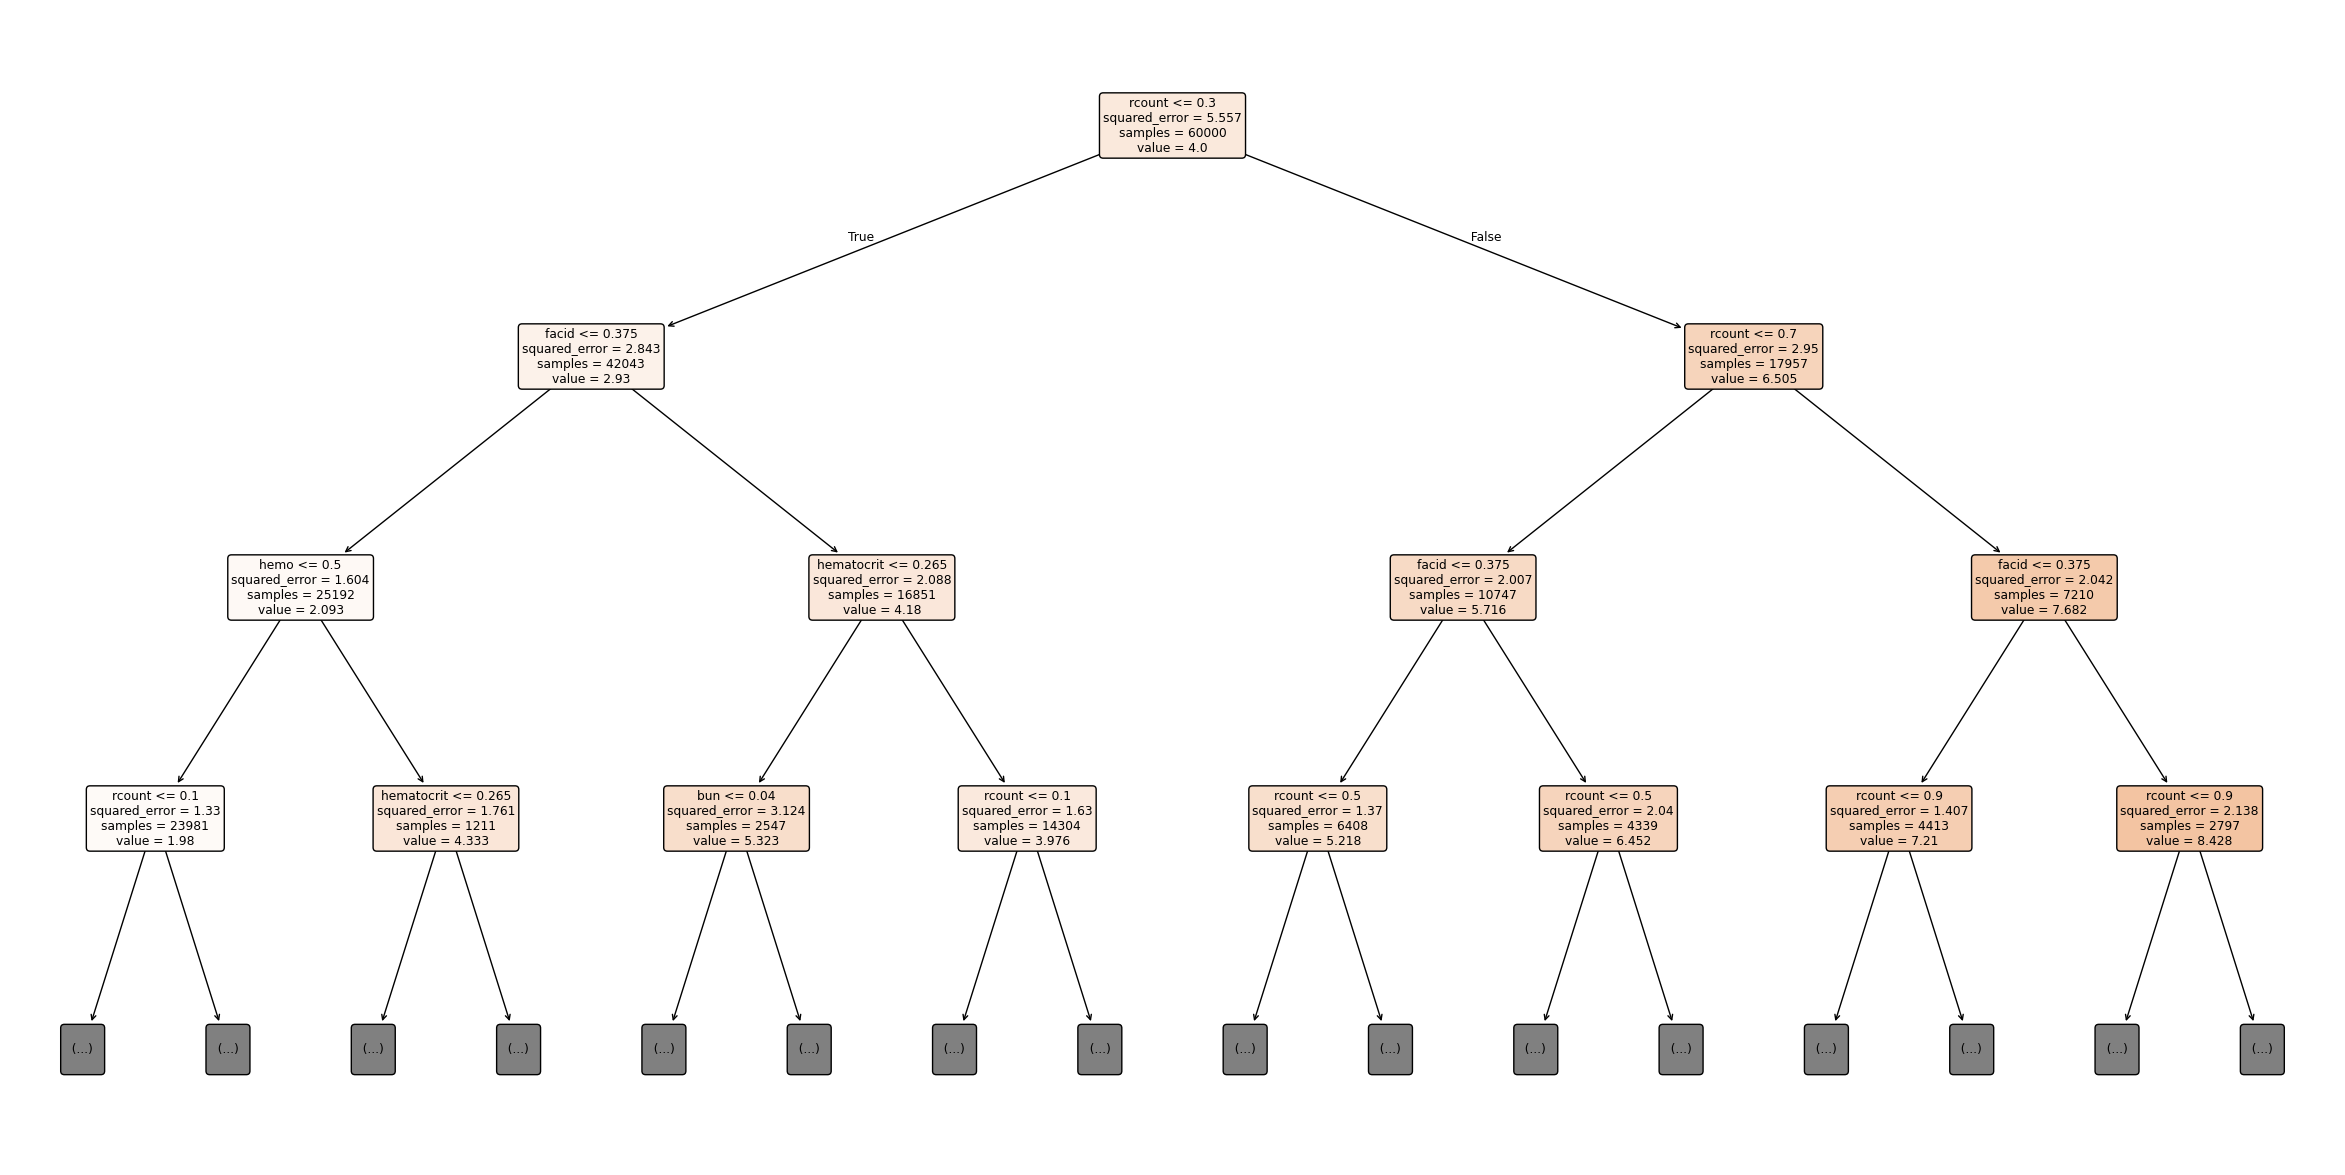

In [97]:
# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(
    ccp_alpha=0.0003470446359305824,
    criterion='squared_error',
    max_depth=10,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=0,
    splitter='best'
)

# Addestramento
trainingML(tree)

# Aggiunge il modello alla lista modelli
elenco_modelli['TREE'] = tree

# Disegna l'albero
plt.figure(figsize=(30,15))
plot_tree(tree, max_depth=3, filled=True, rounded=True, feature_names=FEATURES)
plt.show()

# Definizione architettura Random Forest
Come secondo approccio di Machine Learning tradizionale introduciamo una **Random Forest** di regressione; rispetto all'albero ci aspettiamo prestazioni migliori ma il prezzo da pagare (come spesso accade) sarà una minore trasparenza.

In [99]:
#definisce la random forest
forest = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.0,
    criterion='squared_error',
    max_depth=10,
    max_features=1.0,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    n_estimators=145,
    random_state=0,
    verbose=0,
    warm_start=False
)

# Addestramento
trainingML(forest)

# Aggiunge il modello alla lista modelli
elenco_modelli['FOREST'] = forest

# Definizione architettura Ensemble
Infine definiamo un modello di regressione **ensemble** composto da un albero decisionale, un regressore lineare e uno bayesiano.

In [98]:
# Crea il modello di ensemble
ensemble = VotingRegressor(
    estimators=[
        ('tree', DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=0)),
        ('linear', LinearRegression(copy_X=True, fit_intercept=True)),
        ('bayes', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, tol=0.001, verbose=False))
    ],
    n_jobs=None,
    verbose=False,
    weights=None
)

# Addestramento
trainingML(ensemble)

# Aggiunge il modello alla lista modelli
elenco_modelli['ENSEMBLE'] = ensemble

## Confronto modelli
A questo punto possiamo effettuare il confronto tra le **prestazioni** dei modelli appena definiti:
- Preliminarmente calcoleremo le metriche di valutazione per ognuno dei modelli
- Successivamente le rappresenteremo attraverso una **heatmap**, una visualizzazione molto efficiente che grazie al channel colore facilita il confronto e mette in risalto i modelli migliori e quelli peggiori.

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


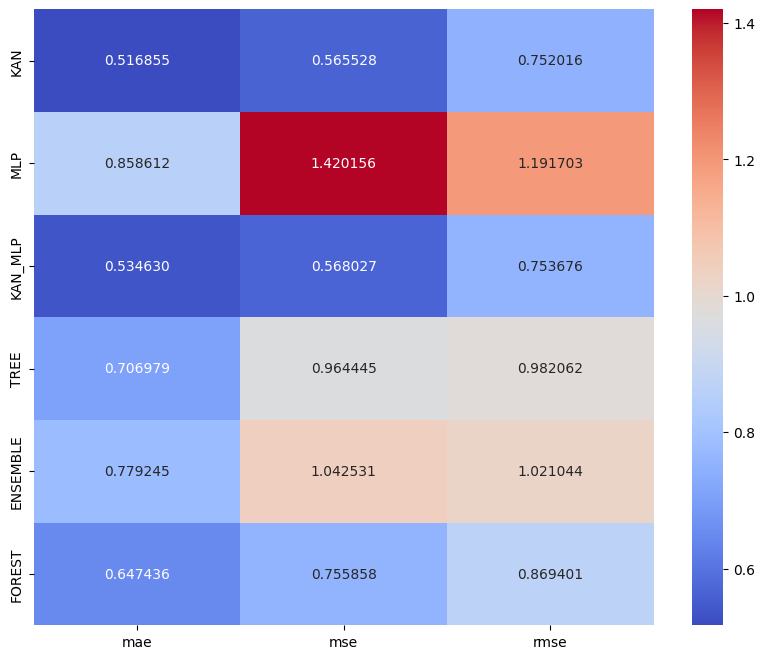

In [101]:
# Definizione funzione per calcolo metriche di errore del modello
def calculate_metrics(model, X, y):
    # Calcolo delle previsioni del modello
    predictions = model.predict(X)

    # Calcolo metriche
    result = {}
    for metric in METRICS:
        metric.reset_state()
        result[metric.name] = float(metric(y, predictions))
    return result

# Definizione funzione visualizzazione heatmap delle performance dei modelli
def performance_heatmap(models, X, y):
    # Inizializzazione del dizionario delle performance
    performance = {metric: [] for metric in METRICS_NAME.values()}
    model_names = []

    for model_name, model in models.items():
        # Calcolo delle metriche per il modello corrente
        result_metrics = calculate_metrics(model, X, y)

        # Aggiunta delle metriche al dizionario delle performance
        for name, result in result_metrics.items():
            performance[name].append(result)

        # Aggiunta del nome del modello alla lista dei nomi dei modelli
        model_names.append(model_name)

    # Creazione di un DataFrame con le performance dei modelli
    df = pd.DataFrame(performance, index=model_names)

    # Visualizzazione della heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.6f')  
    plt.show()

performance_heatmap(elenco_modelli, x_test, y_test)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


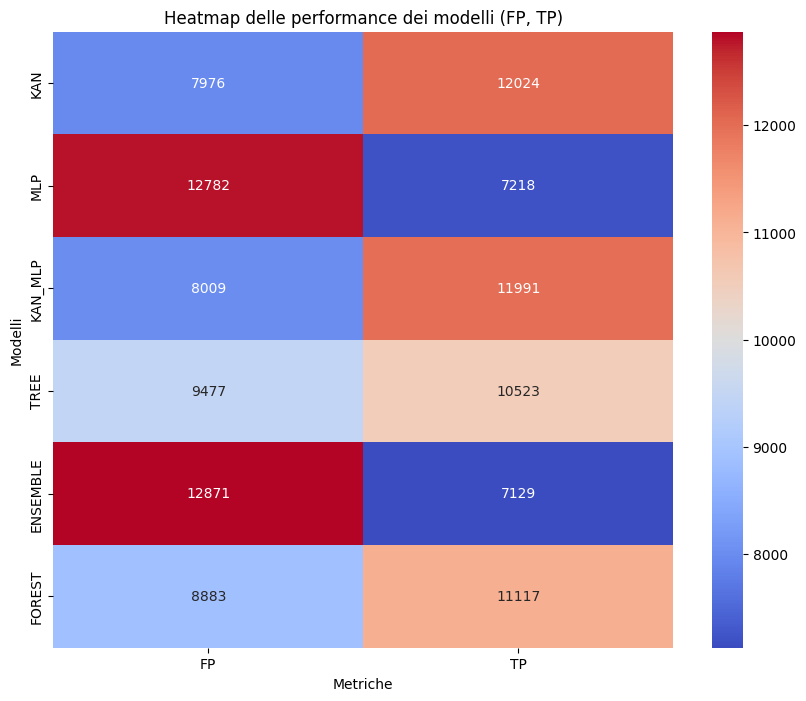

In [103]:
def calculate_error_metrics(model, X, y):

    rounded_predictions = np.round(model.predict(X)).astype(int)

    tp = sum(1 for y_val, pred_val in zip(y, rounded_predictions) if y_val == pred_val)
    fp = sum(1 for y_val, pred_val in zip(y, rounded_predictions) if y_val != pred_val)

    return {'FP': fp,'TP': tp}


def performance_heatmap(models, X, y):
    # Inizializzazione del dizionario delle performance
    performance = { 'FP': [], 'TP': []}
    model_names = []

    for model_name, model in models.items():
        # Calcolo delle metriche di errore per il modello corrente
        result_metrics = calculate_error_metrics(model, X, y)

        # Aggiunta delle metriche al dizionario delle performance
        for name, result in result_metrics.items():
            performance[name].append(result)

        # Aggiunta del nome del modello alla lista dei nomi dei modelli
        model_names.append(model_name)

    # Creazione di un DataFrame con le performance dei modelli
    df = pd.DataFrame(performance, index=model_names)

    # Visualizzazione della heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt='d')
    plt.title("Heatmap delle performance dei modelli (FP, TP)")
    plt.xlabel("Metriche")
    plt.ylabel("Modelli")
    plt.show()

# Chiamata alla funzione performance_heatmap con la lista dei modelli e i dati di test
performance_heatmap(elenco_modelli, x_test, y_test)

# Prestazione dei modelli di apprendimento automatico
Effettuiamo ora un confronto tra i modelli di apprendimento automatico e vediamo in che modo le metriche che stiamo monitorando vengono ottimizzate al passare delle epoche di addestramento.

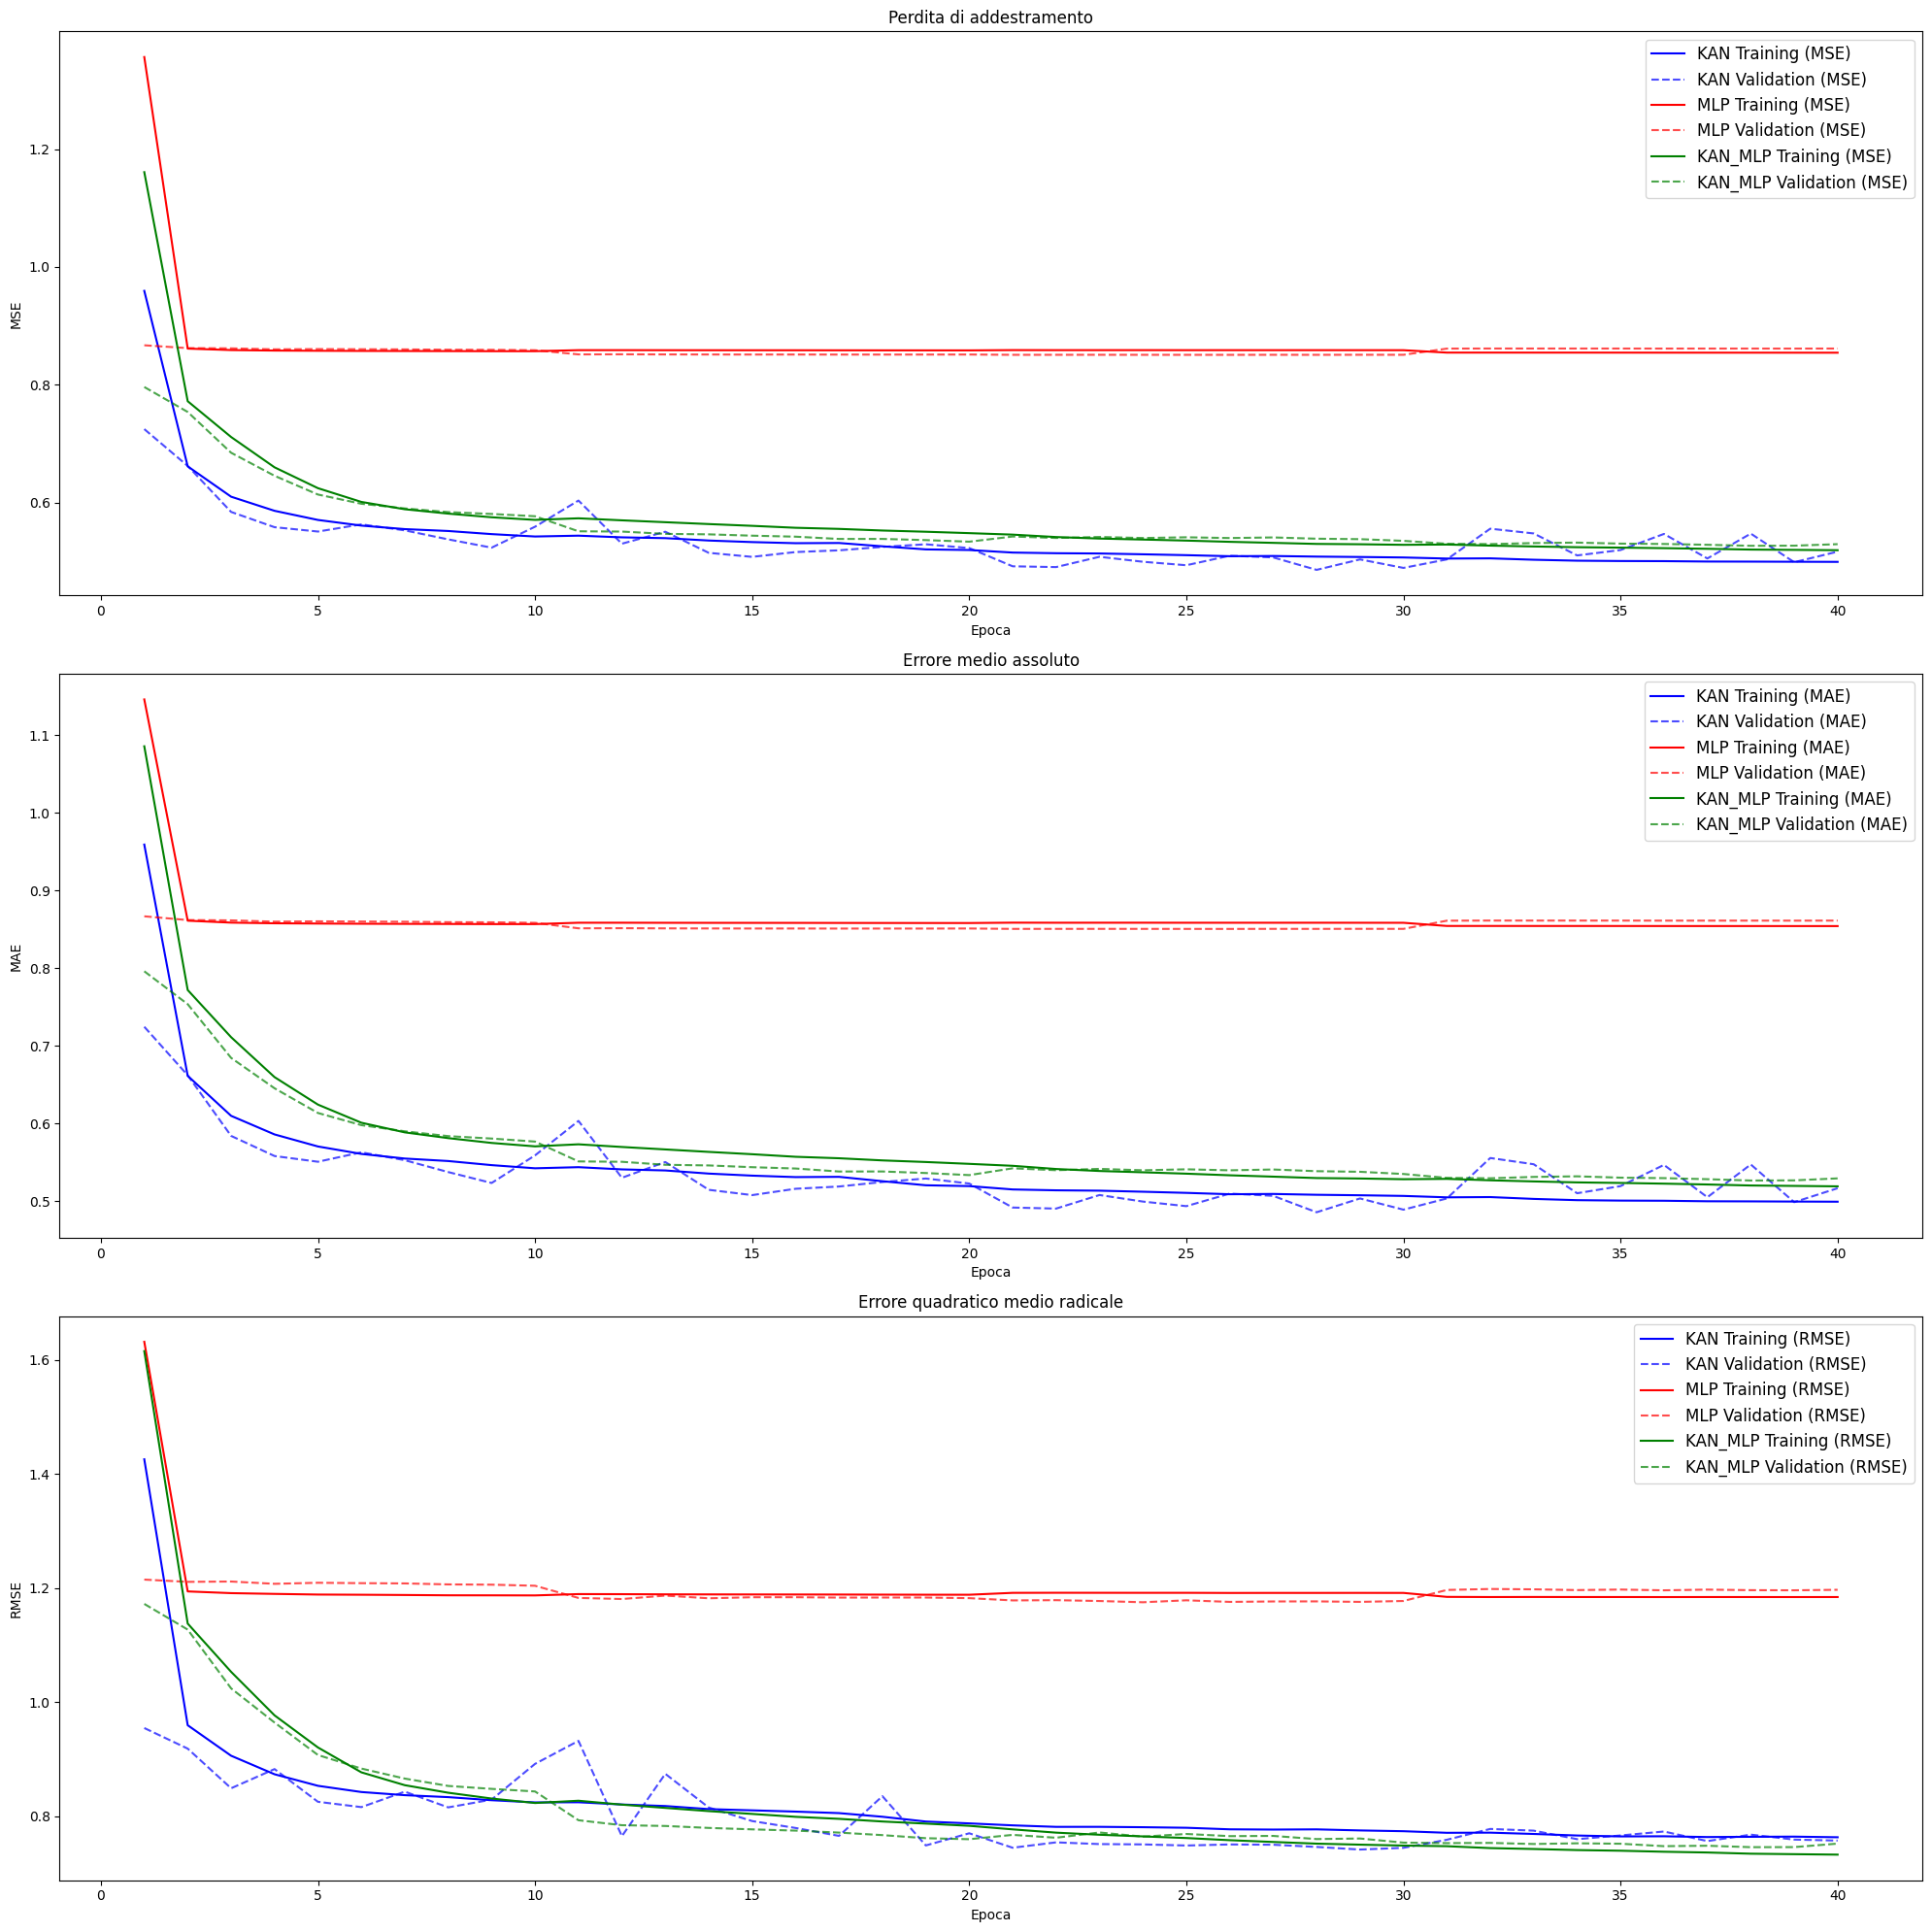

In [105]:
# Definizione funzione di creazione linechart
def plot_data(ax, epochs, metric, val_metric, model_name, metric_name, color):
    ax.plot(epochs, metric, color, label=f'{model_name} Training ({metric_name})') 
    ax.plot(epochs, val_metric, color+'--', alpha=0.7, label=f'{model_name} Validation ({metric_name})') 
    ax.set_xlabel('Epoca')
    ax.legend(fontsize='large')

plt.figure(figsize=(20, 20))

# Crea subplot per ogni metrica
ax1 = plt.subplot(3, 1, 1)
ax1.set_title('Perdita di addestramento')
ax1.set_ylabel('MSE')

ax2 = plt.subplot(3, 1, 2)
ax2.set_title('Errore medio assoluto')
ax2.set_ylabel('MAE')

ax3 = plt.subplot(3, 1, 3)
ax3.set_title('Errore quadratico medio radicale')
ax3.set_ylabel('RMSE')

# Per ogni modello associato al suo colore
for (model_name, history), color in zip(histories.items(), COLORS):

    # Salvataggio performance
    loss, val_loss, mae, val_mae, rmse,val_rmse = history['loss'], history['val_loss'], history['mae'], history['val_mae'], history['rmse'], history['val_rmse']

    # Calcolo numero di epoche 
    epochs = range(1, len(loss) + 1)

    # Creazione 3 plot con performance di train e validation al variare delle epoche
    plot_data(ax1, epochs, loss, val_loss, model_name, 'MSE', color)
    plot_data(ax2, epochs, mae, val_mae, model_name, 'MAE', color)
    plot_data(ax3, epochs, rmse, val_rmse, model_name, 'RMSE', color)

plt.tight_layout()
plt.show()


# Analisi equità di genere

Dopo aver valutato i nostri modelli dal punto di vista prestazionale, ora considereremo l'aspetto dell'**equità algoritmica**.

Confrontiamo i modelli sulle solite metriche, questa volta distinguendo i record in base all'attributo **gender** (che nel nostro caso assume due valori). 

I modelli più equi (dunque preferibili sul piano dell'eqità algoritmica) avranno prestazioni simili per entrambe le categorie considerate.

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


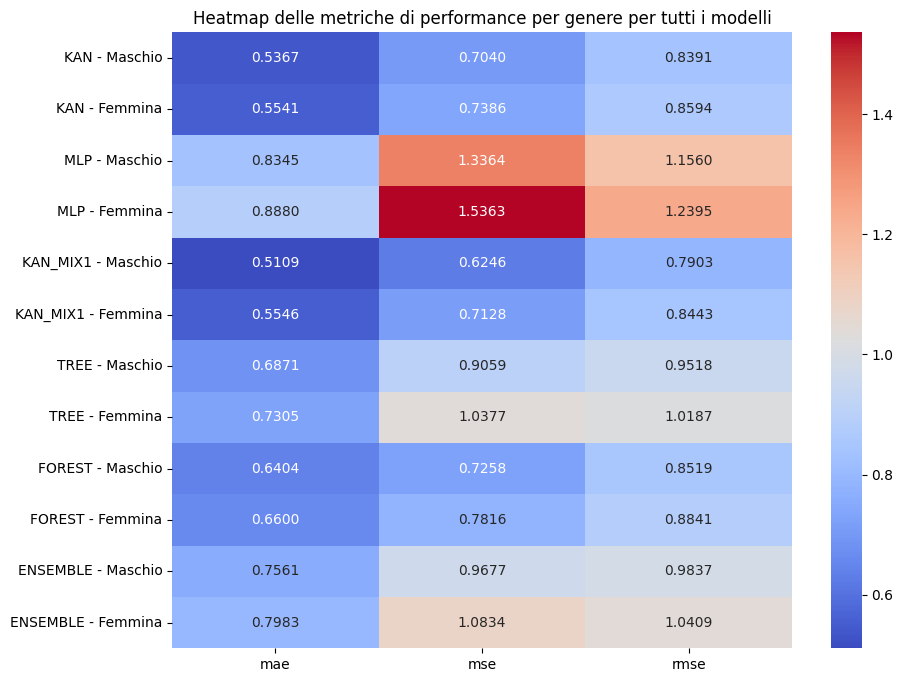

In [21]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
all_results = {}

for model_name, model in elenco_modelli + elenco_modelliML:
    results = {}

    for sg in SUBGROUPS: 
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, CATEGORY] == sg #crea una maschera booleana
        features1 = x_test[subgroup_indices] #salva i record relativi al sottogruppo corrente
        labels = y_test[subgroup_indices]  #salva le label relative al sottogruppo corrente
        
        # Calcolo delle metriche per ciascun sottogruppo
        results[sg] = calculate_metrics(model, features1, labels).values()

    all_results[model_name] = results

# Creazione Dataframe performance
df = pd.DataFrame()

for model_name, results in all_results.items():

    # Definizone dataframe di un modello
    temp_df = pd.DataFrame(results, index=METRICS_NAME.values())
    temp_df.columns = [f'{model_name} - Maschio', f'{model_name} - Femmina']

    # Concatenazione dataframe di un modello ai precedenti
    df = pd.concat([df, temp_df], axis=1)

# Processamento del dataset
df = df.astype(float)
df = df.transpose()

# Visualizzazione della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')
plt.show()

# Trasparenza algoritmica
Tra gli obiettivi principali del nostro progetto c'è quello di valutare se e in che misura le KAN possano introdurre dei miglioramenti nella **trasparenza algoritmica**.

Si tratta di un aspetto fondamentale in particolare su applicazioni che utilizzano dati sensibili come la nostra, per le quali non sarebbero accettabili elaborazioni di tipo black-box.

Per studiare la spiegabilità abbiamo utilizzato tre metodi:

- Feature importance
- LIME (Local Interpretable Model-agnostic Explanations)
- Grafo di rappresentazione dei livelli

I primi due sono **agnostici** cioè applicabili a qualsiasi modello, il terzo è invece specifico per l'architettura delle KAN.

## Feature importance

Il metodo di trasparenza algoritmica "Feature Importance" valuta l'importanza di ciascuna caratteristica di un dataset nel contribuire al modello predittivo. Generalmente, questa valutazione viene effettuata misurando l'impatto della rimozione o della permutazione di una caratteristica sulle performance del modello.

In [22]:
# Calcola feature importance del modello
def calculate_feature_importance(model, X, y):
    # Verifica se il modello ha l'attributo 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        # Altrimenti, utilizza la 'permutation_importance'
        results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
        importance = results.importances_mean

    # Ritorna un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(FEATURES, importance))
    return feature_importance

# Calcola l'importanza delle caratteristiche per ogni modello
caratteristiche = []
for nome, modello in elenco_modelli + elenco_modelliML:
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━

In [23]:
importanze = {}

for nome_modello, importanza_caratteristiche in caratteristiche:
    importanze[nome_modello] = {}

    # Stampa il nome del modello
    print(f"\n Modello: {nome_modello}")
    
    # Calcola totale delle importanze
    totale = sum(abs(imp) for imp in importanza_caratteristiche.values())
    
    # Stampa le caratteristice e la loro importanza normalizzata
    for caratteristica, importanza in importanza_caratteristiche.items():
        importanze[nome_modello][caratteristica] = importanza / totale
        print(f"Caratteristica: {caratteristica}, Importanza: {importanza:.2f}, Importanza nortmalizzata: {((importanza / totale)):.2f}")
        


 Modello: KAN
Caratteristica: vdate, Importanza: 0.00, Importanza nortmalizzata: 0.00
Caratteristica: rcount, Importanza: 6.57, Importanza nortmalizzata: 0.69
Caratteristica: gender, Importanza: -0.00, Importanza nortmalizzata: -0.00
Caratteristica: dialysis, Importanza: 0.09, Importanza nortmalizzata: 0.01
Caratteristica: asthma, Importanza: 0.10, Importanza nortmalizzata: 0.01
Caratteristica: irondef, Importanza: 0.20, Importanza nortmalizzata: 0.02
Caratteristica: pneum, Importanza: 0.09, Importanza nortmalizzata: 0.01
Caratteristica: subdep, Importanza: 0.20, Importanza nortmalizzata: 0.02
Caratteristica: psychmaj, Importanza: 0.67, Importanza nortmalizzata: 0.07
Caratteristica: depress, Importanza: 0.08, Importanza nortmalizzata: 0.01
Caratteristica: psychother, Importanza: 0.11, Importanza nortmalizzata: 0.01
Caratteristica: fibrosis, Importanza: 0.02, Importanza nortmalizzata: 0.00
Caratteristica: malnutr, Importanza: 0.09, Importanza nortmalizzata: 0.01
Caratteristica: hemo, I

Stampiamo graficamente i risultati della feature importance:

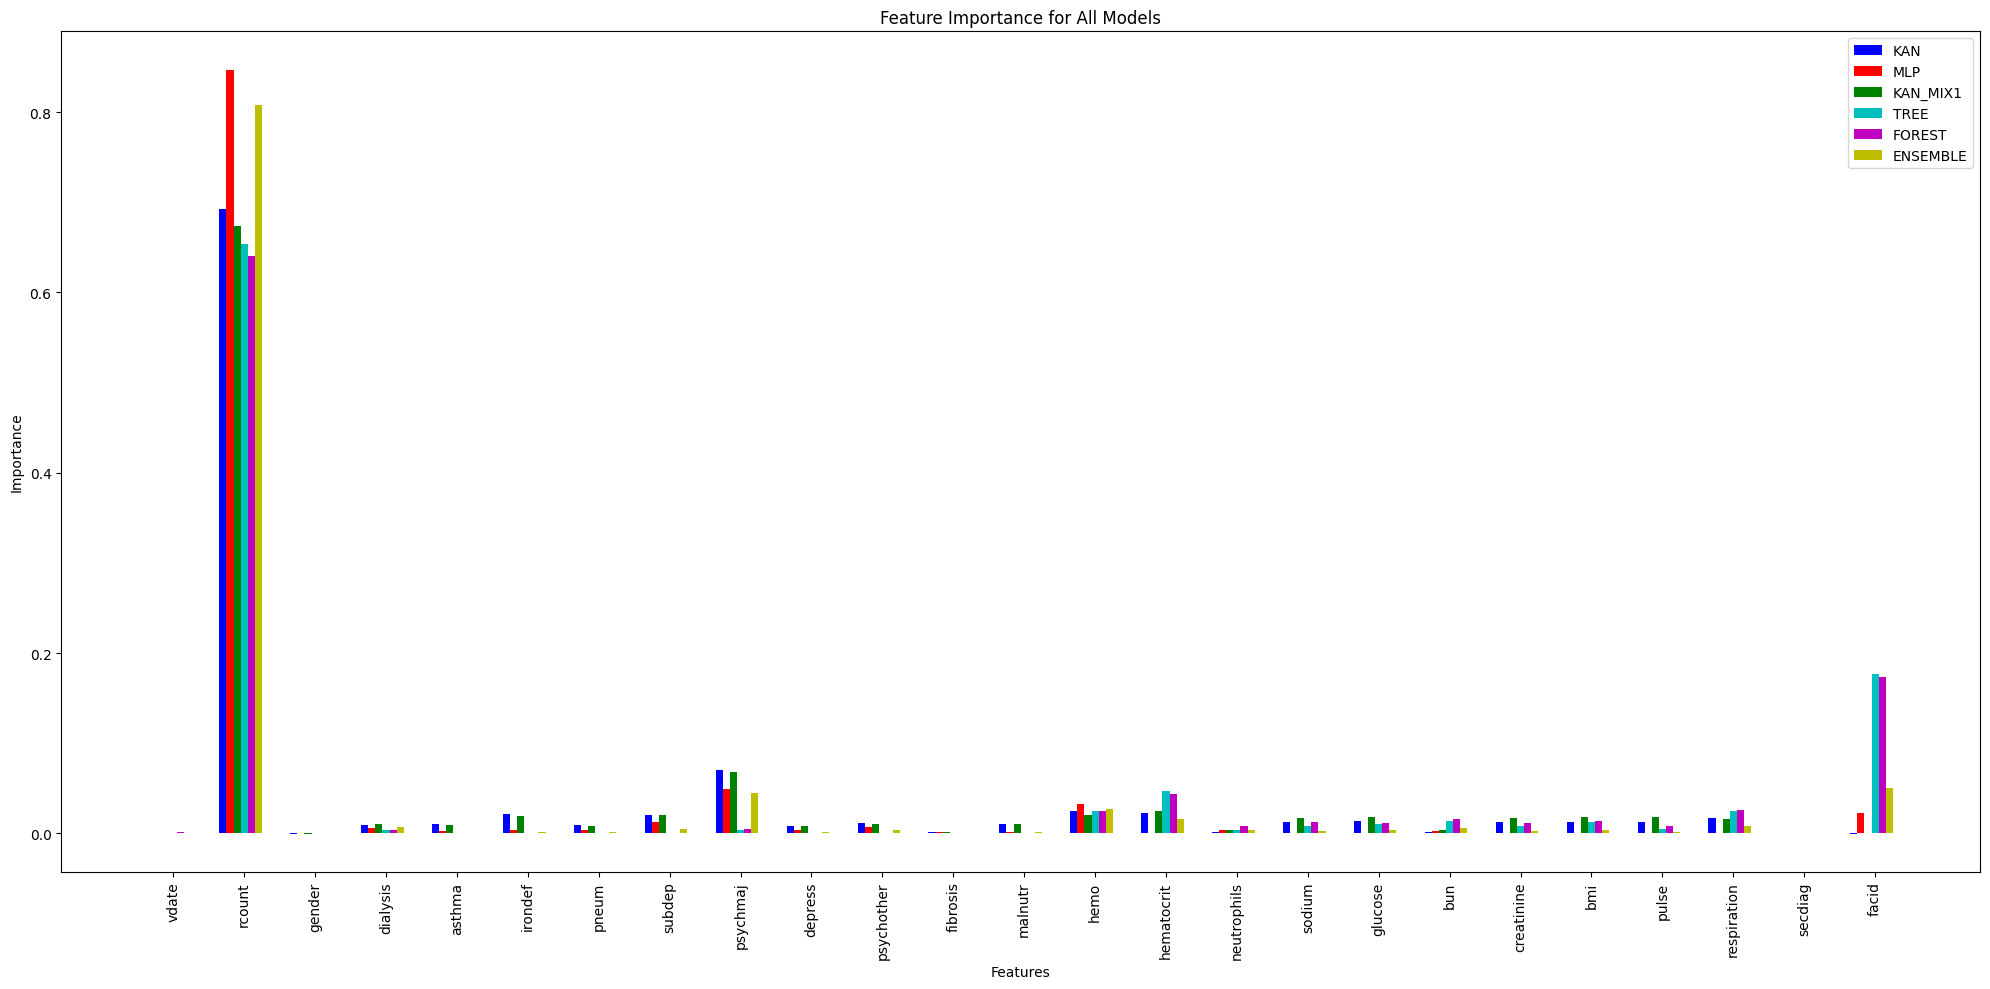

In [24]:
# Crea le etichette per l'asse x
features = list(importanze[list(importanze.keys())[0]].keys())
x = np.arange(len(features))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))

# Calcola la larghezza delle barre in base al numero di modelli
BAR_WIDTH = 0.6
bar_width = BAR_WIDTH / len(importanze)

# Crea le barre per l'importanza delle caratteristiche per ogni modello di un certo colore
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(x - BAR_WIDTH/2 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=COLORS[i % len(COLORS)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)
ax.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

# LIME

Il metodo LIME (Local Interpretable Model-agnostic Explanations) è una tecnica di trasparenza algoritmica che spiega le previsioni di modelli complessi **su singole istanze** tramite modelli interpretabili e locali. 

LIME perturba i dati di input generando un set di dati simili e valuta le predizioni del modello su questi dati perturbati. Successivamente, costruisce un modello interpretabile (ad esempio, un regressore lineare) con cui effettua le predizioni sui record nell'area locale intorno all'istanza di interesse. Questo approccio permette di comprendere come il modello complesso prende decisioni per specifici campioni mediante l'approssimazione con un modello più semplice.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


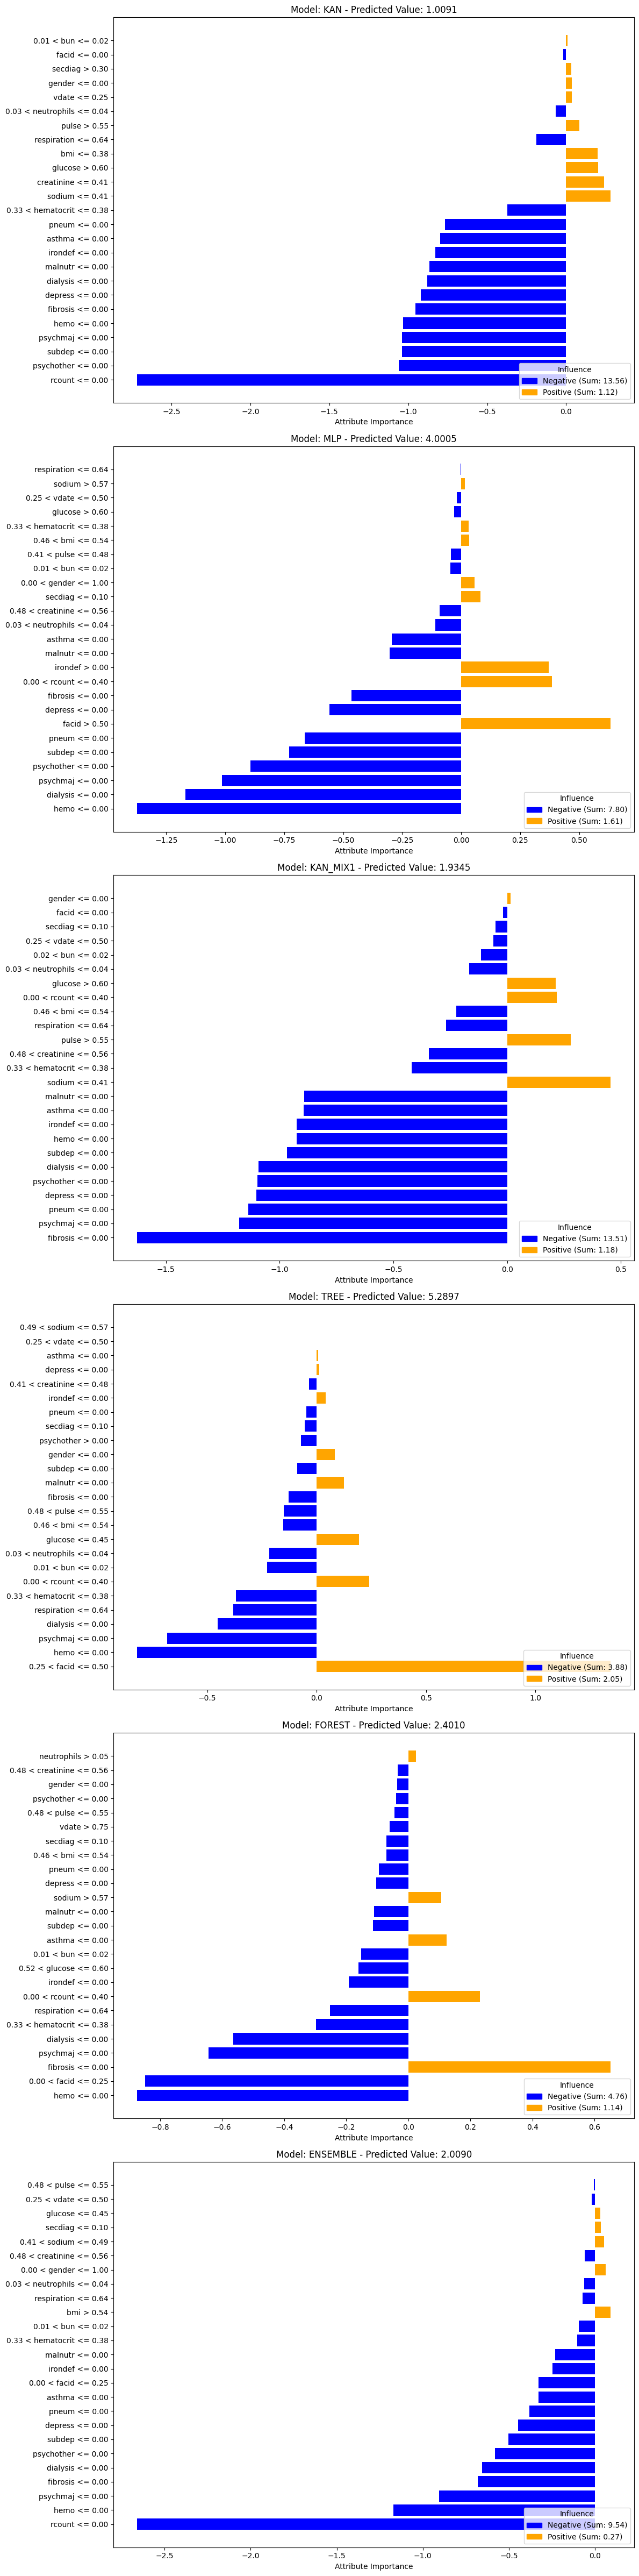

In [25]:
# Conversione di x_train e x_test in array numpy
X_train_np = x_train.numpy()
X_test_np = x_test.numpy()

# Creazione di un oggetto LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=FEATURES,
    class_names=['target'],
    mode='regression'
)

# Creazione di una figura con un subplot per ogni modello
fig, axs = plt.subplots(len(elenco_modelli + elenco_modelliML), 1, figsize=(12, 8*len(elenco_modelli + elenco_modelliML)), squeeze=False)

# Per ogni modello seleziona un'istanza casuale e spiegazione dell'istanza selezionata con LIME
for i, (model_name, model) in enumerate(elenco_modelli + elenco_modelliML):

    instance = X_test_np[random.randint(0, len(X_test_np)-1)]

    explanation = explainer.explain_instance(
        instance, 
        lambda x: model.predict(tf.convert_to_tensor(x.reshape(-1, x_train.shape[1]))),
        num_features=N_FEATURES
    )
    
    # Estrazione degli attributi e delle importanze
    attributi, importances = zip(*explanation.as_list())

    colors = ['blue' if imp < 0 else 'orange' for imp in importances]
    
    # Creazione di un barplot per le importanze
    ax = axs[i, 0]
    ax.barh(range(len(attributi)), importances, color=colors)
    ax.set_yticks(range(len(attributi)))
    ax.set_yticklabels(attributi)
    ax.set_xlabel('Attribute Importance')
    
    # Calcolo della previsione del modello sull'istanza selezionata
    predicted_value = model.predict(tf.convert_to_tensor(instance.reshape(1, -1)))

    predicted_value_str = ', '.join(f'{v:.4f}' for v in np.atleast_1d(predicted_value.flatten()))
    
    # Impostazione del titolo del subplot
    ax.set_title(f'Model: {model_name} - Predicted Value: {predicted_value_str}')
    ax.set_facecolor('white')
    
    # Calcolo della somma delle importanze positive e negative
    positive_sum = sum(imp for imp in importances if imp > 0)
    negative_sum = abs(sum(imp for imp in importances if imp < 0))
    
    # Aggiunta di una leggenda con le somme delle importanze
    ax.legend(
        [plt.Rectangle((0,0),1,1, color=c) for c in ['blue', 'orange']],
        [f'Negative (Sum: {negative_sum:.2f})', f'Positive (Sum: {positive_sum:.2f})'],
        title='Influence', loc='lower right'
    )

# Visualizzazione del grafico
plt.tight_layout()
plt.show()



## Grafo di Architettura della KAN
Questo approccio, già utilizzato dagli autori dell'articolo introduttivo alle KAN, permette di visualizzare i grafici delle funzioni spline ai **nodi** della rete.

Si ricorda che al nodo $n$ della rete corrisponde la funzione $$l_n = \sum_{i_{0}=1}^{units_{l-1}}{\phi_{n,i_0}}$$

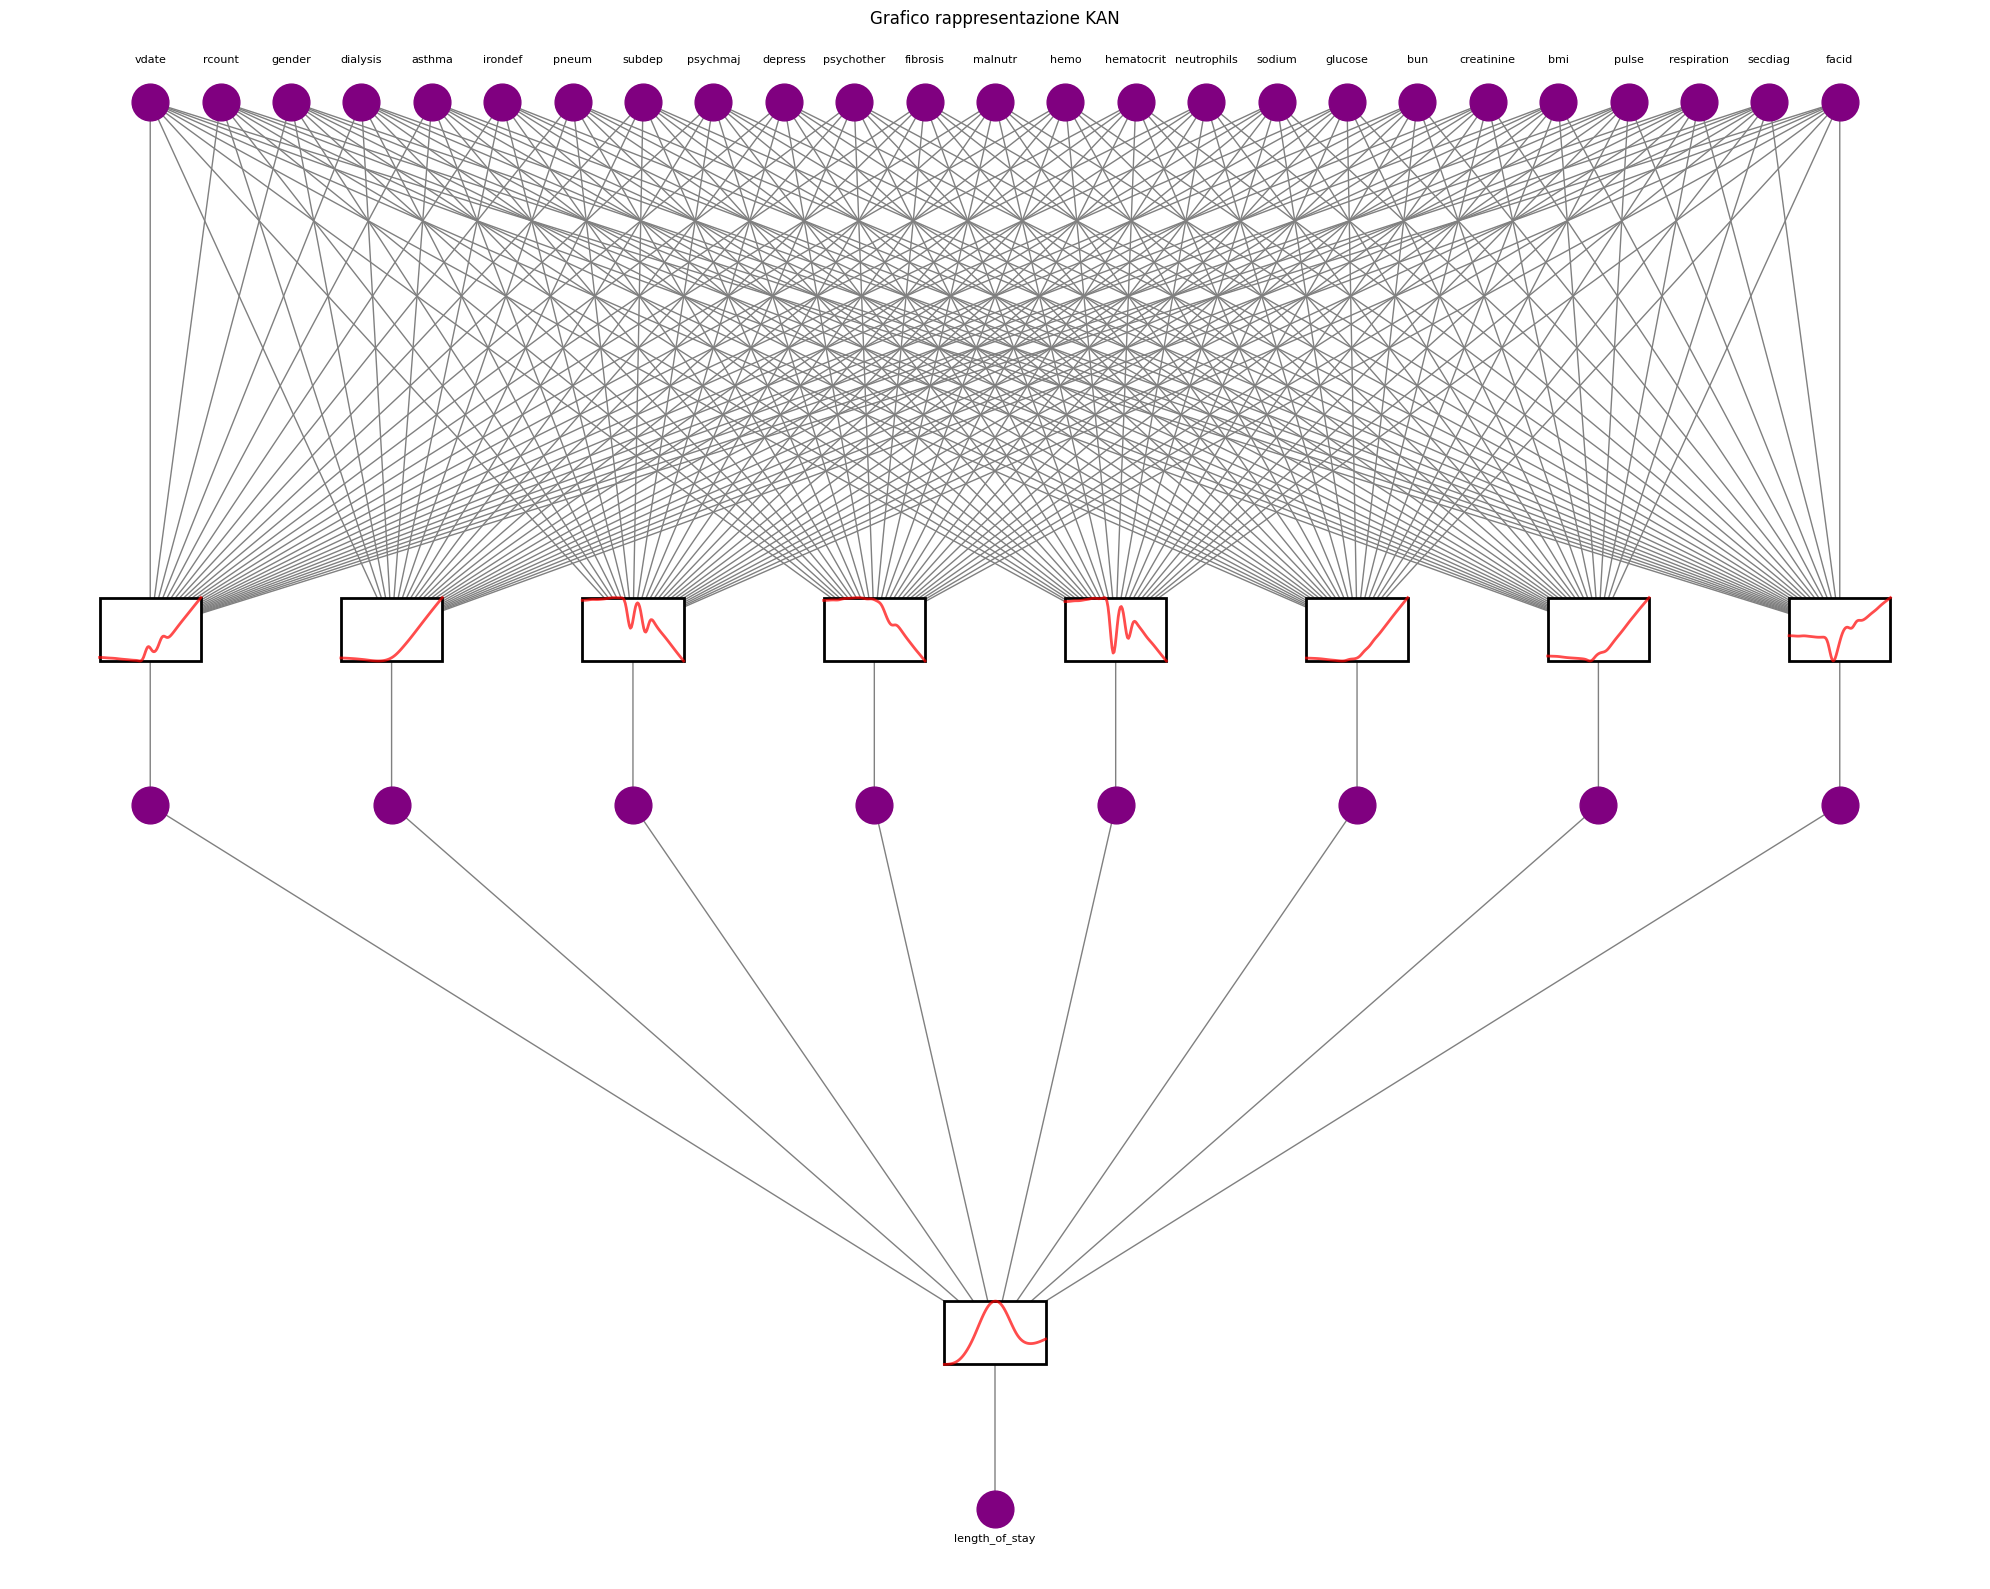

In [26]:
# Definizione della funzione 'get_all_splines_from_model' che estrae tutte le spline da un modello
def get_all_splines_from_model(model):
    # Inizializzazione di una lista vuota per contenere tutte le spline
    all_splines = []
    # Per ogni layer nel modello
    for layer in model.layers:
        # Se il layer è di tipo DenseKAN
        if isinstance(layer, DenseKAN):

            splines = layer.get_spline_list()
            all_splines.append(splines)
            
    return all_splines


# Definizione della funzione 'create_kan_tree_from_model' che crea un grafo da un modello
def create_kan_tree_from_model(model, features):
    # Creazione di un grafo diretto
    G = nx.DiGraph()
    
    # Aggiunta dei nodi di input al grafo
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Aggiunta dei layer nascosti e di output al grafo
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    # Restituisce il grafo
    return G


# Definizione della funzione 'draw_merged_edges' che disegna gli archi e le spline nel grafo
def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    # Inizializzazione di una lista vuota per contenere i punti di fusione
    merge_points = []
    # Per ogni nodo nel grafo
    for target in G.nodes():
        # Ottiene la lista degli archi entranti nel nodo
        in_edges = list(G.in_edges(target))
        # Se ci sono più di un arco entrante
        if len(in_edges) > 1:
            # Calcola la posizione del punto di fusione
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            # Aggiunge il punto di fusione alla lista dei punti di fusione
            merge_points.append(merge_point)
            
            # Per ogni arco entrante
            for source, _ in in_edges:
                # Calcola la posizione di partenza dell'arco
                start = np.array(pos[source])
                # Disegna l'arco dal punto di partenza al punto di fusione
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            # Disegna un arco dal punto di fusione al nodo
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    # Ottiene tutte le spline dal modello
    spline_collection = get_all_splines_from_model(kan)



    sum_of_spline = []

    knots_list = []
    for spline_model in spline_collection:
        for i_lambda in range(len(spline_model[0])):
            knots_list.append(spline_model[0][0].t)

            func = [spline_model[j_lambda][i_lambda] for j_lambda in range(len(spline_model))]

            sum_of_spline.append(func)

    


    square_size = 0.06  # Dimensione fissa del quadrato
    # Per ogni punto di fusione
    for i, point in enumerate(merge_points):
        # Se c'è una spline corrispondente al punto di fusione
        if i < len(sum_of_spline):
            # Disegna un quadrato attorno al punto di fusione
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Disegna la spline B all'interno del quadrato
            spl = sum_of_spline[i]

            xx = np.linspace(knots_list[i][0, 0], knots_list[i][0, -1], 100) 
            yy = 0
            for s in spl:
                yy += s(xx)
            
            # Normalizza i valori della spline B per adattarsi al quadrato
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            # Disegna la spline B normalizzata
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    # Restituisce la lista dei punti di fusione
    return merge_points


# Crea un grafo dal modello
G = create_kan_tree_from_model(kan, FEATURES)

# Imposta il grafico
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Disegna gli archi e i quadrati con le spline nel grafo
merge_points = draw_merged_edges(G, pos, ax, kan)

# Disegna i nodi
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Imposta l'ordine di sovrapposizione per i nodi

# Aggiunge le etichette
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Aggiunge l'etichetta "length_of_stay" sotto il nodo più basso
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

# Imposta il titolo del grafico
plt.title("Grafico rappresentazione KAN")
# Nasconde gli assi
plt.axis('off')
# Ridimensiona il layout del grafico
plt.tight_layout()
# Mostra il grafico
plt.show()

# Tuning (non è da tenere nel notebook, ma era piu comodo averlo direttamente qui)

In [70]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        num_layers = hp.Int('num_layers', 1, 3)
        for i in range(num_layers):
            grid_range = hp.Float(f'grid_range_min_{i}', 1.0, 5.0)
            model.add(DenseKAN(
                units=hp.Int(f'units_{i}', 1, 16),
                grid_size=hp.Int(f'grid_size_{i}', 8, 32),
                grid_range=[
                    -grid_range,
                    grid_range
                ],
                spline_order=hp.Int(f'spline_order_{i}', 2, 3)
            ))
        
        model.add(DenseKAN(1))

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
        
        opt = tf.keras.optimizers.get(optimizer)
        opt.learning_rate = learning_rate

        model.compile(
            optimizer=opt,
            loss='mean_absolute_error',
            metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
        )
        return model


def run_tuner(x_train, y_train, x_test, y_test, input_shape):
    hypermodel = MyHyperModel(input_shape=input_shape)

    tuner = BayesianOptimization(
        hypermodel,
        objective='val_loss',
        max_trials=200,
        directory="./modelli_salvati",
        project_name='retina_kan'
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    x_train = tf.convert_to_tensor(x_train)
    y_train = tf.convert_to_tensor(y_train)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train.numpy())):
        print(f"Fold {fold + 1}")
        
        x_train_fold = tf.gather(x_train, train_indices)
        x_val_fold = tf.gather(x_train, val_indices)
        y_train_fold = tf.gather(y_train, train_indices)
        y_val_fold = tf.gather(y_train, val_indices)

        tuner.search(
            x_train_fold, y_train_fold,
            epochs=100,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[early_stopping, lr_scheduler]
        )

    tuner.results_summary()
    best_model = tuner.get_best_models(num_models=1)[0]

    test_loss, test_mae = best_model.evaluate(x_test, y_test)
    print(f"Test MAE: {test_mae}")

    best_model.save('best_retina_kan_model.h5')

    return best_model

N_FEATURES = x_train.shape[1]
best_model = run_tuner(x_train, y_train, x_test, y_test, input_shape=(N_FEATURES,))

Fold 1

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
1.4467            |1.4467            |grid_range_min_0
8                 |8                 |units_0
32                |32                |grid_size_0
2                 |2                 |spline_order_0
0.0013572         |0.0013572         |learning_rate
rmsprop           |rmsprop           |optimizer

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2.8513 - mae: 2.8513 - val_loss: 0.6100 - val_mae: 0.6100 - learning_rate: 0.0014
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5253 - mae: 0.5253 - val_loss: 0.4288 - val_mae: 0.4288 - learning_rate: 0.0014
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4341 - mae: 0.4341 - val_loss: 0.4302 - val_mae: 0.4302 - learning_rate: 0.0014
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4149 - mae: 0.4149 - val_loss: 0.4338 - val_mae: 0.4338 - l

KeyboardInterrupt: 

# Tuning MLP

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras_tuner import RandomSearch, HyperModel
from sklearn.model_selection import KFold

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        num_layers = hp.Int('num_layers', 1, 9)
        for i in range(num_layers):
            model.add(layers.Dense(
                units=hp.Int(f'units_{i}', 4, 256, step=4),
                activation=hp.Choice(f'activation_{i}', ['relu', 'elu', 'selu']),
                kernel_regularizer=regularizers.l2(hp.Float(f'l2_{i}', 1e-4, 1e-2, sampling='log'))
            ))
        
        model.add(layers.Dense(1))

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])

        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        model.compile(
            optimizer=opt,
            loss='mean_absolute_error',
            metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
        )
        return model


def run_tuner(x_train, y_train, x_test, y_test, input_shape):
    hypermodel = MyHyperModel(input_shape=input_shape)

    tuner = RandomSearch(
        hypermodel,
        objective='val_loss',
        max_trials=50,
        directory="./modelli_salvati",
        project_name='retina_kan'
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    x_train = tf.convert_to_tensor(x_train)
    y_train = tf.convert_to_tensor(y_train)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train.numpy())):
        print(f"Fold {fold + 1}")
        
        x_train_fold = tf.gather(x_train, train_indices)
        x_val_fold = tf.gather(x_train, val_indices)
        y_train_fold = tf.gather(y_train, train_indices)
        y_val_fold = tf.gather(y_train, val_indices)

        tuner.search(
            x_train_fold, y_train_fold,
            epochs=50,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[early_stopping, lr_scheduler]
        )

    tuner.results_summary()
    best_model = tuner.get_best_models(num_models=1)[0]

    test_loss, test_mae = best_model.evaluate(x_test, y_test)
    print(f"Test MAE: {test_mae}")

    best_model.save('best_retina_kan_model.h5')

    return best_model

# Assicurati che x_train, y_train, x_test, y_test siano definiti correttamente
N_FEATURES = x_train.shape[1]
best_model = run_tuner(x_train, y_train, x_test, y_test, input_shape=(N_FEATURES,))


Trial 13 Complete [00h 02m 15s]
val_loss: 0.7587072849273682

Best val_loss So Far: 0.5934496521949768
Total elapsed time: 00h 23m 34s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
8                 |1                 |num_layers
124               |200               |units_0
selu              |relu              |activation_0
0.0012664         |0.00084988        |l2_0
0.0009152         |0.00057854        |learning_rate
adam              |adam              |optimizer
184               |232               |units_1
selu              |relu              |activation_1
0.00010342        |0.00011467        |l2_1
248               |232               |units_2
relu              |elu               |activation_2
0.00084301        |0.0033192         |l2_2
68                |240               |units_3
elu               |elu               |activation_3
0.00034269        |0.00062705        |l2_3
52                |32                |units_4
selu              |relu      

KeyboardInterrupt: 

# Misto kan-mlp

# Modelli ML

In [ ]:
from kerastuner import HyperModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import VotingRegressor

class DecisionTreeHyperModel(HyperModel):
    def build(self, hp):
        model = DecisionTreeRegressor(
            max_depth=hp.Int('max_depth', 2, 10),
            ccp_alpha=hp.Float('ccp_alpha', 0.0, 0.1),
            min_samples_split=hp.Int('min_samples_split', 2, 5),
            random_state=0
        )
        return model

class RandomForestHyperModel(HyperModel):
    def build(self, hp):
        model = RandomForestRegressor(
            n_estimators=hp.Int('n_estimators', 50, 150),
            max_depth=hp.Int('max_depth', 2, 10),
            random_state=0
        )
        return model

class VotingRegressorHyperModel(HyperModel):
    def build(self, hp):
        tree = DecisionTreeRegressor(
            max_depth=hp.Int('tree_max_depth', 2, 10),
            ccp_alpha=hp.Float('tree_ccp_alpha', 0.0, 0.1),
            min_samples_split=hp.Int('tree_min_samples_split', 2, 5),
            random_state=0
        )
        linear = LinearRegression()
        bayes = BayesianRidge()
        model = VotingRegressor(estimators=[('tree', tree), ('linear', linear), ('bayes', bayes)])
        return model


In [ ]:
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from skopt.space import Real, Categorical, Integer

# Define the hyperparameters for the DecisionTreeRegressor
tree_param_space = {
    'max_depth': Integer(2, 10),
    'ccp_alpha': Real(0.0, 0.1),
    'min_samples_split': Integer(2, 5),
}

# Define the hyperparameters for the RandomForestRegressor
forest_param_space = {
    'n_estimators': Integer(50, 150),
    'max_depth': Integer(2, 10),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf': Integer(1, 5),
    'bootstrap': Categorical([True, False]),
}

# Define the hyperparameters for the VotingRegressor
voting_param_space = {
    'tree__max_depth': Integer(2, 10),
    'tree__ccp_alpha': Real(0.0, 0.1),
    'tree__min_samples_split': Integer(2, 5),
}

# Create the BayesSearchCV object for the DecisionTreeRegressor
tree_search = BayesSearchCV(
    estimator=DecisionTreeRegressor(random_state=0),
    search_spaces=tree_param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=0
)

# Run the search for the DecisionTreeRegressor
tree_search.fit(xML_train, yML_train)

# Create the BayesSearchCV object for the RandomForestRegressor
forest_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    search_spaces=forest_param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=0
)

# Run the search for the RandomForestRegressor
forest_search.fit(xML_train, yML_train)

# Create the BayesSearchCV object for the VotingRegressor
voting_search = BayesSearchCV(
    estimator=VotingRegressor(estimators=[('tree', DecisionTreeRegressor(random_state=0)), ('linear', LinearRegression()), ('bayes', BayesianRidge())]),
    search_spaces=voting_param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=0
)

# Run the search for the VotingRegressor
voting_search.fit(xML_train, yML_train)


BayesSearchCV(cv=3,
              estimator=VotingRegressor(estimators=[('tree',
                                                     DecisionTreeRegressor(random_state=0)),
                                                    ('linear',
                                                     LinearRegression()),
                                                    ('bayes',
                                                     BayesianRidge())]),
              n_jobs=-1, optimizer_kwargs={'base_estimator': 'GP'},
              random_state=0,
              search_spaces={'tree__ccp_alpha': Real(low=0.0, high=0.1, prior='uniform', transform='normalize'),
                             'tree__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'tree__min_samples_split': Integer(low=2, high=5, prior='uniform', transform='normalize')})

In [ ]:
best_tree_model = tree_search.best_estimator_
best_forest_model = forest_search.best_estimator_
best_voting_model = voting_search.best_estimator_

NameError: name 'tree_search' is not defined

In [ ]:
print("Best DecisionTreeRegressor parameters:")
print(best_tree_model.get_params())

# Print the parameters of the best RandomForestRegressor model
print("\nBest RandomForestRegressor parameters:")
print(best_forest_model.get_params())

# Print the parameters of the best VotingRegressor model
print("\nBest VotingRegressor parameters:")
print(best_voting_model.get_params())

Best DecisionTreeRegressor parameters:
{'ccp_alpha': 0.0003470446359305824, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'}

Best RandomForestRegressor parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 145, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}

Best VotingRegressor parameters:
{'estimators': [('tree', DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=0)), ('linear', LinearRegression()), ('bayes', BayesianRidge())], 'n_jobs': None, 'verbose': Fa